In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
trainDf=pd.read_csv("train.csv")
print(trainDf.head())

   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         

In [3]:
print(trainDf.shape)

(42000, 785)


In [4]:
ytrain=trainDf["label"].values
X_train=trainDf.iloc[:,1:].values.reshape(-1,28,28)
X_train=X_train.astype(np.float32)/255.0
print(f"Size of y_train : {len(ytrain)}\nSize of X_train : {X_train.shape}\n")

Size of y_train : 42000
Size of X_train : (42000, 28, 28)



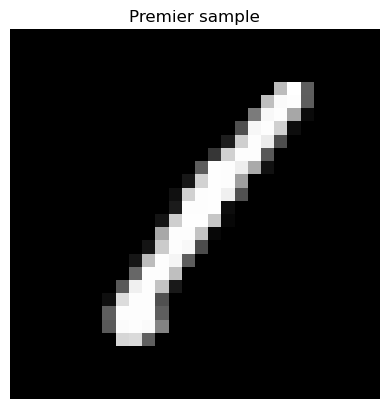

In [5]:
plt.imshow(X_train[0],cmap="gray")
plt.title("Premier sample")
plt.axis("off")
plt.show()

In [6]:
sobelX=np.array([
    [-1,0,1],
    [-2,0,2],
    [-1,0,1]
]) #detection de bords horizontaux

sobelY=np.array([
    [-1,-2,-1],
    [0,0,0],
    [1,2,1]
]) #detection de bords verticaux

prewittX=np.array([
    [-1,0,1],
    [-1,0,1],
    [-1,0,1]
]) #detection de bords horizontaux (comme sobelX mais moins marqué)

laplacien=np.array([
    [0,-1,0],
    [-1,4,-1],
    [0,-1,0]
]) #detection de bords toutes directions

laplacienPlus=np.array([
    [-1,-1,-1],
    [-1,8,-1],
    [-1,-1,-1]
]) #detection de bords toutes directions (laplacien plus marqué)

blur=np.array([
    [1/9,1/9,1/9],
    [1/9,1/9,1/9],
    [1/9,1/9,1/9]
]) #flou

gaussien=np.array([
    [1/16,2/16,1/16],
    [2/16,4/16,2/16],
    [1/16,2/16,1/16]
]) #flou plus doux

sharpen=np.array([
    [0,-1,0],
    [-1,5,-1],
    [0,-1,0]
]) #accentuation contours


avrPooling2dKernel=np.array([
    [1/4,1/4],
    [1/4,1/4]
]) #Fait la moyenne des 4 éléments = avrPooling de dim 2,2

In [7]:
def padding(img,pad_size=0):
    if pad_size==0:
        return img
    else:
        newImg=np.zeros((img.shape[0]+2*pad_size,img.shape[1]+2*pad_size))
        for w in range(pad_size,newImg.shape[0]-pad_size):
            for h in range(pad_size,newImg.shape[1]-pad_size):
                newImg[w][h]=img[w-pad_size][h-pad_size]
        return newImg

In [8]:
def createRandomKernels(nb_kernels,dim):
    kernels=[]
    for i in range(nb_kernels):
        kernels.append(np.random.randn(dim[0],dim[1]))
    return kernels

In [9]:
def maxPooling2d(images,dim):
    maxed=[]
    for img in images:
        newImg=np.zeros((((img.shape[0]-dim[0])//dim[0])+1,((img.shape[1]-dim[1])//dim[1])+1))
        for w in range(newImg.shape[0]):
            for h in range(newImg.shape[1]):
                cur_max=float("-inf")
                for kw in range(dim[0]):
                    for kh in range(dim[1]):
                        if img[w*dim[0]+kw][h*dim[1]+kh]>cur_max:
                            cur_max=img[w*dim[0]+kw][h*dim[1]+kh]
                newImg[w][h]=cur_max
        maxed.append(newImg)
    return maxed

In [10]:
def averagePooling2d(images,dim):
    averaged=[]
    for img in images:
        newImg=np.zeros((((img.shape[0]-dim[0])//dim[0])+1,((img.shape[1]-dim[1])//dim[1])+1))
        for w in range(newImg.shape[0]):
            for h in range(newImg.shape[1]):
                avr=0
                for kw in range(dim[0]):
                    for kh in range(dim[1]):
                        avr+=img[w*dim[0]+kw][h*dim[1]+kh]
                newImg[w][h]=avr/(dim[0]*dim[1])
        averaged.append(newImg)
    return averaged

In [11]:
def conv2d(inputs,out_dim,kernel_size,pad_size=0,stride=1,specificKernel=None,extractKernels=False):
    outputs=[]
    kernels=[]
    padded=[]
    for img in inputs:
        padded.append(padding(img,pad_size=pad_size))
    for resultante in range(out_dim):
        if specificKernel is not None:
            if len(specificKernel)!=len(inputs):
                if len(specificKernel)>len(inputs):
                    k=specificKernel[:len(inputs)]
                else:
                    k=specificKernel*(len(inputs)//len(specificKernel))+specificKernel[:len(inputs)%len(specificKernel)]
            else:
                k=specificKernel
        else:
            k=createRandomKernels(len(inputs),kernel_size)
        kernels.append(k)

        newImg=np.zeros((((padded[0].shape[0]-kernel_size[0])//stride)+1,((padded[0].shape[1]-kernel_size[1])//stride)+1))

        for w in range(newImg.shape[0]):
            for h in range(newImg.shape[1]):
                res=0
                for kw in range(kernel_size[0]):
                    for kh in range(kernel_size[1]):
                        tot=0
                        for i,img in enumerate(padded):
                            tot+=k[i][kw][kh]*img[w*stride+kw][h*stride+kh]
                        res+=tot
                newImg[w][h]=res

        outputs.append(newImg)
    
    if extractKernels:
        return outputs,kernels
    return outputs

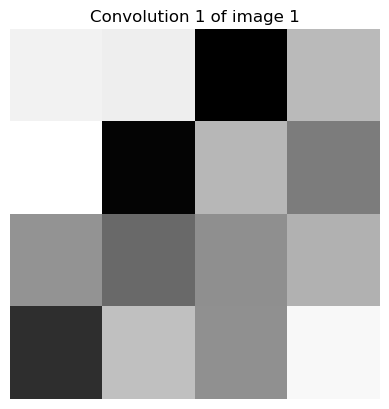

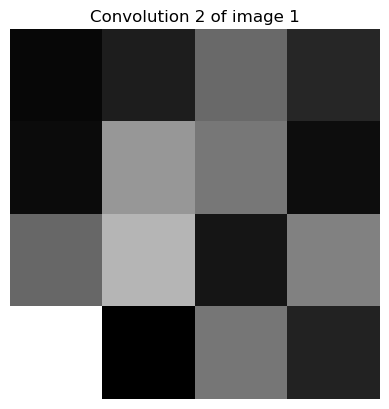

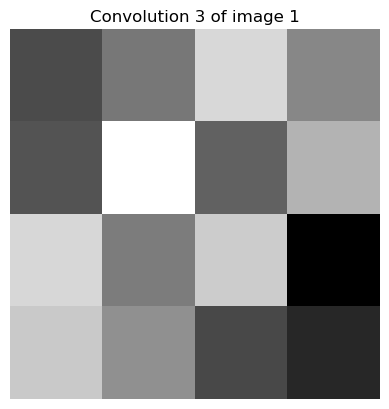

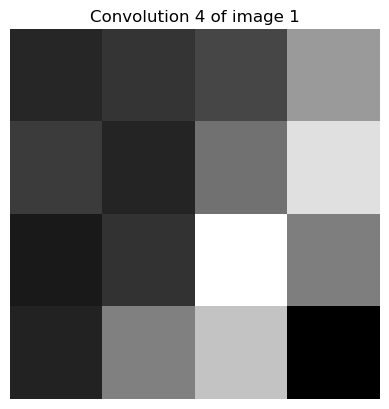

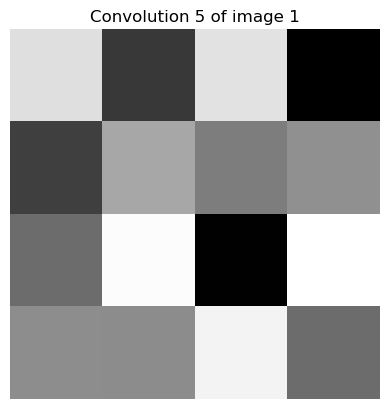

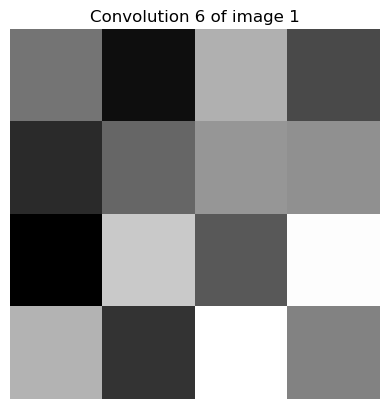

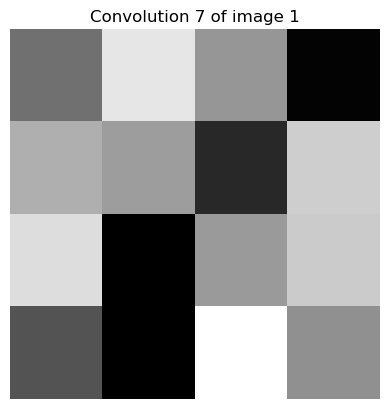

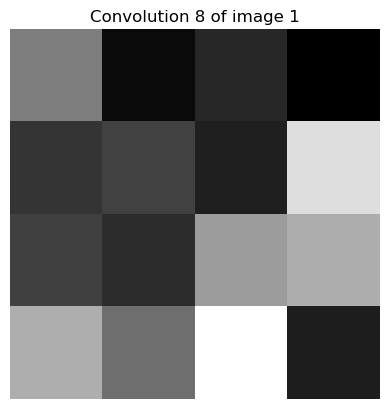

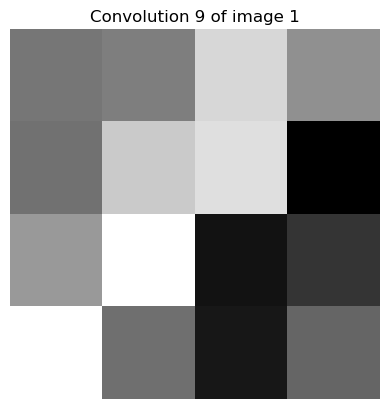

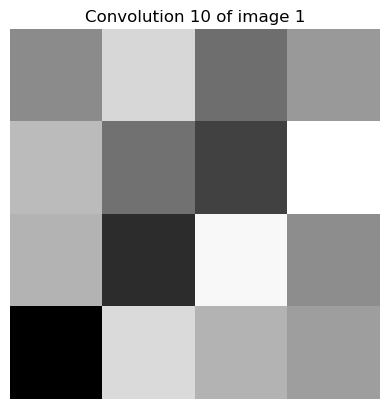

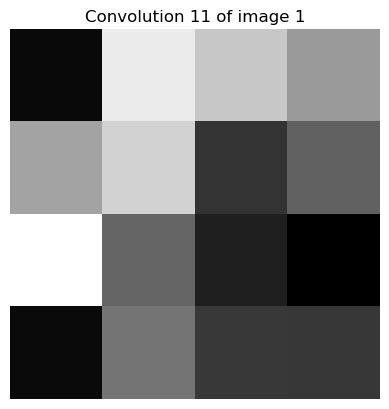

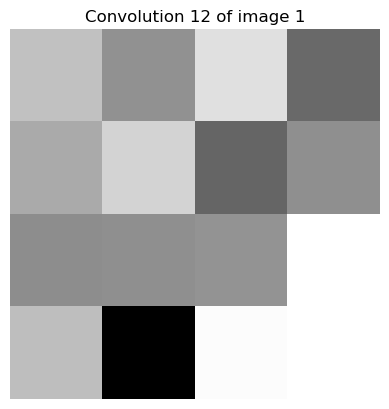

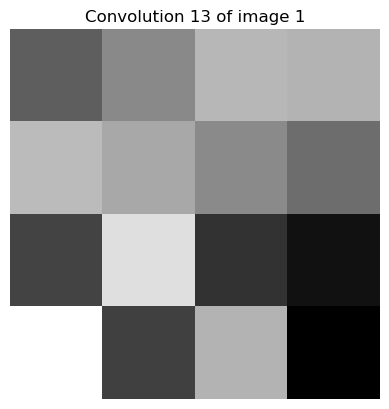

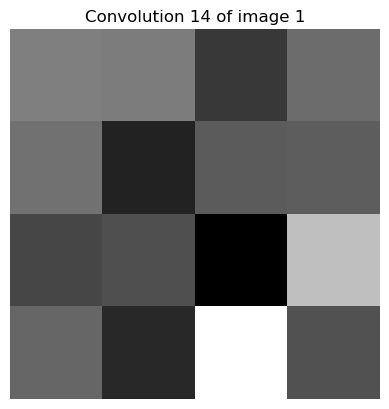

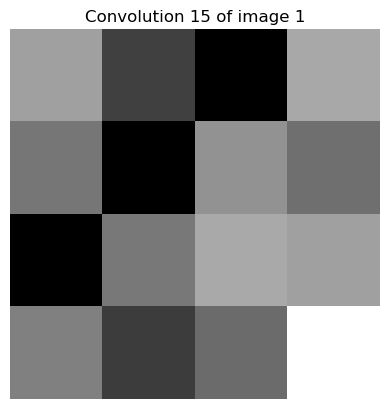

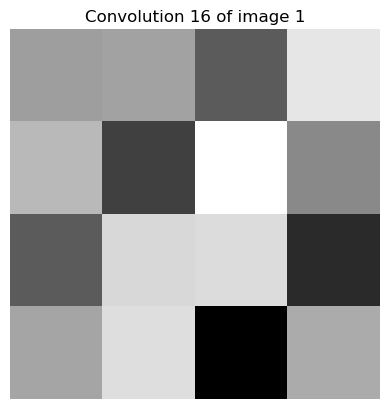

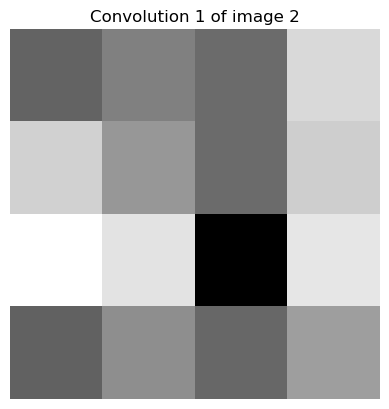

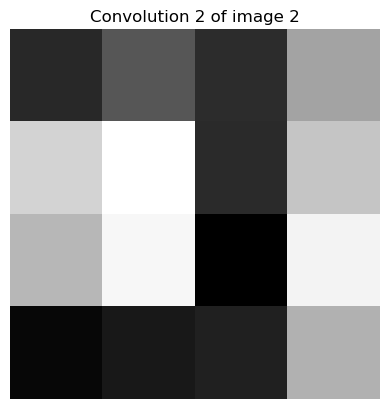

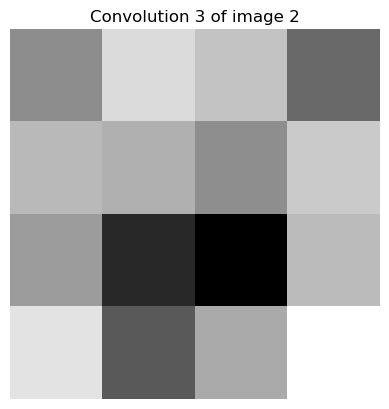

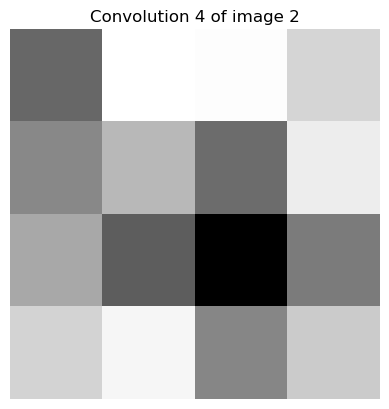

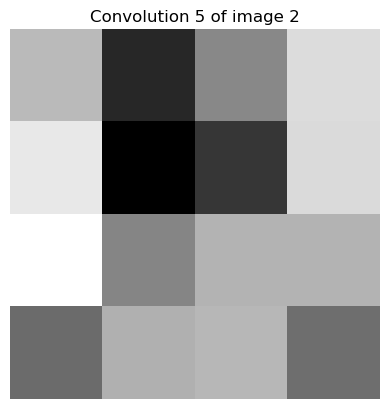

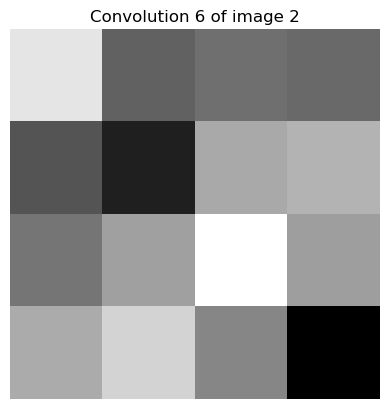

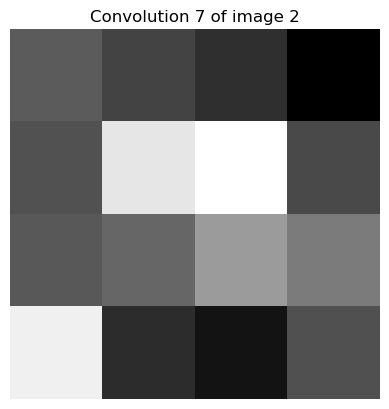

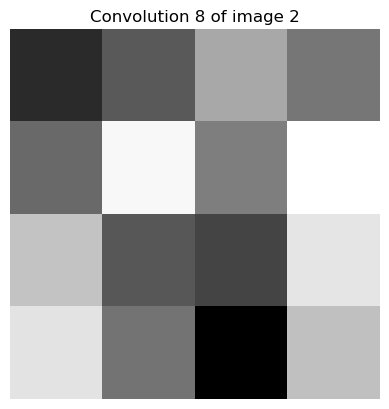

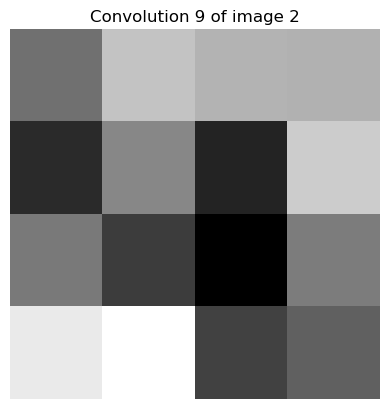

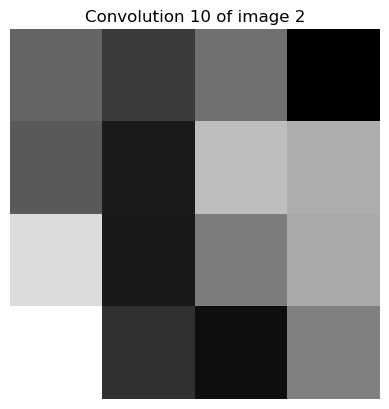

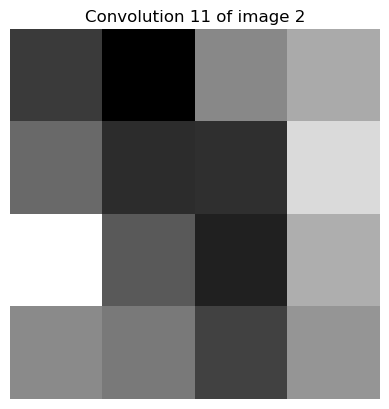

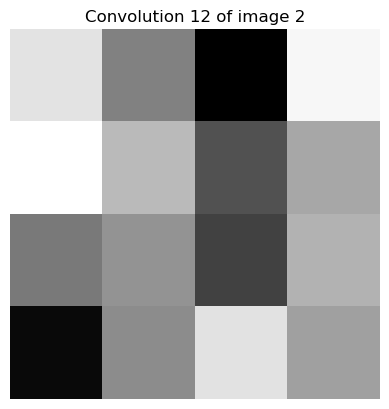

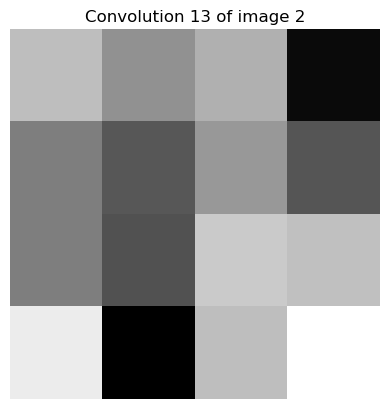

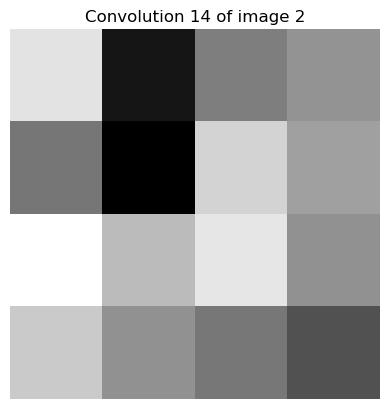

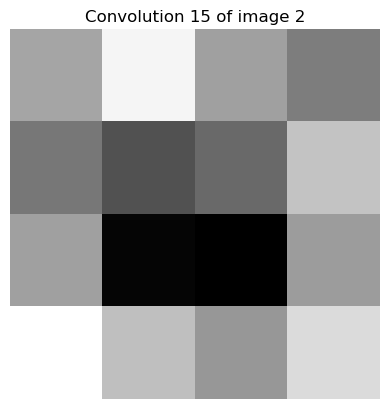

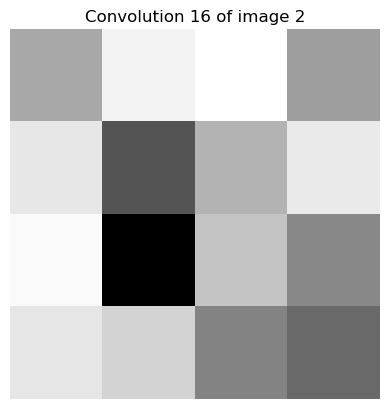

In [12]:
kernels=[sobelX,sobelY,prewittX,laplacien,laplacienPlus,blur,gaussien,sharpen]
#si je veux passer une image BGR il faut d'abord la passer en gris ou séparer les cannaux en plusieurs images
images=[X_train[0],X_train[1]]
conv1=[]
for img in images:
    conv=(conv2d([img],6,(5,5),pad_size=0))
    avr=averagePooling2d(conv,(2,2))
    conv2=conv2d(avr,16,(5,5),pad_size=0)
    avr2=averagePooling2d(conv2,(2,2))
    conv1.append(avr2)
for i in range(len(conv1)):
    for m in range(len(conv1[i])):
        plt.imshow(conv1[i][m],cmap="gray")
        plt.title(f"Convolution {m+1} of image {i+1}")
        plt.axis("off")
        plt.show()

In [13]:
flat=[]
for i in range(len(conv1)):
    fla=[]
    for convs in conv1[i]:
        fla.append(convs.flatten())
    ca=np.concatenate(fla)
    flat.append(ca)

In [14]:
print(len(flat[0]))

256


In [ ]:
def createRandomBias(nb_neurones):
    bias=np.random.randn(nb_neurones)
    return bias

In [52]:
def createRandomWeights(nb_inputs,nb_neurones):
    limit=np.sqrt(6/(nb_inputs+nb_neurones))
    weights=np.random.uniform(-limit,limit,size=(nb_neurones,nb_inputs))
    return weights

In [34]:
def denseLayer(inputs,nb_neurones,fonctionActivation=None,specificBias=None,specificWeights=None,returnWeightsAndBias=False,alpha=0.01):
    bias=[]
    weights=[]
    outputs=[]
    if specificBias is None:
        bias=createRandomBias(nb_neurones)
    elif len(specificBias)==nb_neurones:
        bias=specificBias
    else:
        print(f"Erreur : le nombre de biais assigné ({len(specificBias)}) n'est pas équivalent au nombre de neurones : {nb_neurones}")
    if specificWeights is None:
        weights=createRandomWeights(len(inputs),nb_neurones)
    elif len(specificWeights)==nb_neurones and len(specificWeights[0])==len(inputs):
        weights=specificWeights
    else:
        print(f"Erreur : le nombre de poids assigné n'est pas correct : {len(specificWeights)} pour {nb_neurones} neurones et {len(specificWeights[0])} pour {len(inputs)} inputs.")
    for neurone in range(nb_neurones):
        result=0
        for inpu in range(len(inputs)):
            result+=(inputs[inpu]*weights[neurone][inpu])
        if fonctionActivation=="ReLU":
            result=max(0,result)
        if fonctionActivation=="Leaky ReLU":
            if result<0:
                result=alpha*result
        if fonctionActivation=="Sigmoid":
            result=(1/(1+np.exp(-result)))
        if fonctionActivation=="Tanh":
            result=((np.exp(result)-np.exp(-result))/(np.exp(result)+np.exp(-result)))
        result+=bias[neurone]
        outputs.append(result)
    if fonctionActivation=="Softmax":
        exps=np.exp(outputs-np.max(outputs))
        outputs=exps/np.sum(exps)
    if returnWeightsAndBias:
        return outputs,weights,bias
    return outputs

In [25]:
test=np.random.randn(3)
print(test)
outputs=denseLayer(test,2,fonctionActivation="Leaky ReLU")
print(outputs)
outputs2=denseLayer(outputs,3,fonctionActivation="Softmax")
print(outputs2)

[-0.20455867  1.00603649  0.32124707]
[0.5969043130087898, 0.40434954563179126]
[0.0223834  0.47532813 0.50228847]


In [19]:
y_train=[]
for y in range(len(ytrain)):
    yt=np.zeros(10)
    yt[ytrain[y]]=1
    y_train.append(yt)

In [20]:
print(y_train[0])

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [54]:
outputs1,weights1,bias1=[],createRandomWeights(256,128),createRandomBias(128)
outputs2,weights2,bias2=[],createRandomWeights(128,84),createRandomBias(84)
outputs3,weights3,bias3=[],createRandomWeights(84,10),createRandomBias(10)
#256 -> 128 -> 84 -> 10
for f,fla in enumerate(flat):
    outputs1.append(denseLayer(fla,128,fonctionActivation="ReLU",specificBias=bias1,specificWeights=weights1))
    outputs2.append(denseLayer(outputs1[f],84,fonctionActivation="ReLU",specificBias=bias2,specificWeights=weights2))
    outputs3.append(denseLayer(outputs2[f],10,fonctionActivation="Softmax",specificBias=bias3,specificWeights=weights3))

print(outputs3[0])
print(outputs3[1])

[7.64167869e-02 1.15733778e-06 2.67734210e-05 6.26804906e-06
 9.23481862e-01 2.26811261e-05 1.62738924e-10 4.71954092e-09
 1.30502162e-05 3.14155627e-05]
[2.11555759e-30 2.33647300e-37 3.06337230e-36 1.11951839e-04
 2.43751344e-06 9.99885611e-01 1.16607248e-37 1.50769705e-57
 8.77679154e-54 1.27375851e-16]


In [43]:
MSE=[]
for out in range(len(outputs3)):
    MSE.append((np.sum((outputs3[out]-y_train[out])**2))/10)
print(MSE[1])

0.2


In [38]:
print(outputs3[1])

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
